# 4. Higher-dimensional boxes

In [1]:
using IntervalArithmetic

We can approximate general sets in 1D using finite unions of intervals.
The equivalent in higher dimensions is to use a union of **boxes**.

An $n$-dimensional **(interval) box** is a Cartesian product $X_1 \times X_2 \times \cdots \times X_n$ of intervals $X_i$.


Computationally, an $n$-dimensional box is just a vector of $n$ intervals. For performance we need to use fixed-size arrays from the `StaticArrays.jl` package. In `IntervalArithmetic.jl` these are wrapped into the `IntervalBox` type.

We can construct an `IntervalBox` in `IntervalArithmetic.jl` in a couple of ways:

In [8]:
X = IntervalBox(1..2, 3..4)

[1, 2] × [3, 4]

In [9]:
using Plots

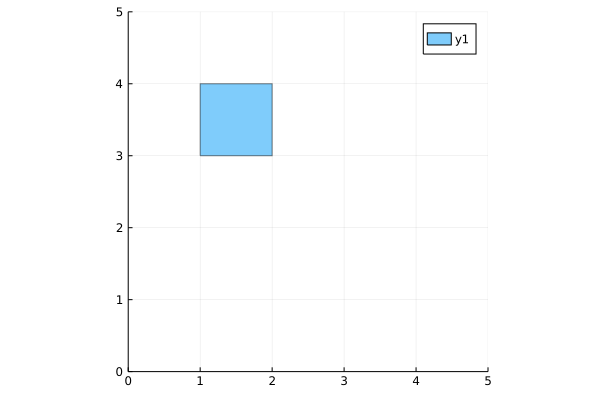

In [10]:
plot(X, ratio=1, xlim=(0, 5), ylims=(0,5))

In [11]:
(1..2) × (3..4)   # \times<TAB>

[1, 2] × [3, 4]

In [12]:
X = IntervalBox(1..2, 4)  # second argument is the number of dimensions

[1, 2] × [1, 2] × [1, 2] × [1, 2]

In [13]:
X × (5..6)

[1, 2] × [1, 2] × [1, 2] × [1, 2] × [5, 6]

In [14]:
typeof(X)

IntervalBox{4,Float64}

In [3]:
using Plots

## Multidimensional functions

Evaluating a multidimensional scalar-valued function over a box is as simple as 

In [15]:
f( (x, y) ) = x^2 + y

f (generic function with 1 method)

In [16]:
X = (-1..1) × (-2..2)

[-1, 1] × [-2, 2]

In [17]:
f(X)

[-2, 3]

In [18]:
f( (x, y) ) = x^2 + 2x + y

f (generic function with 1 method)

In [19]:
f(X)

[-4, 5]

If the function is vector-valued, for performance reasons it is advisable to return an `SVector` from the `StaticArrays.jl` package:

In [ ]:
]add StaticArrays

In [24]:
using StaticArrays

In [25]:
g( (x, y) ) = SVector(x^2 + y, x - y)

g (generic function with 1 method)

In [27]:
g( (1, 2) )

2-element SArray{Tuple{2},Int64,1,2} with indices SOneTo(2):
  3
 -1

In [28]:
g(X)

2-element SArray{Tuple{2},Interval{Float64},1,2} with indices SOneTo(2):
 [-2, 3]
 [-3, 3]

In [29]:
IntervalBox(g(X))

[-2, 3] × [-3, 3]

An alternative is to return an `IntervalBox`, but this makes the function less generic, for example if you wish to mix evaluating the same function at floating-point vectors and `IntervalBox`es.

## Plotting `IntervalBox`es

As we mentioned previously, using the `Plots.jl` package we can plot `IntervalBox`es:

In [30]:
X = (1..2) × (3..4)

[1, 2] × [3, 4]

In [31]:
using Plots

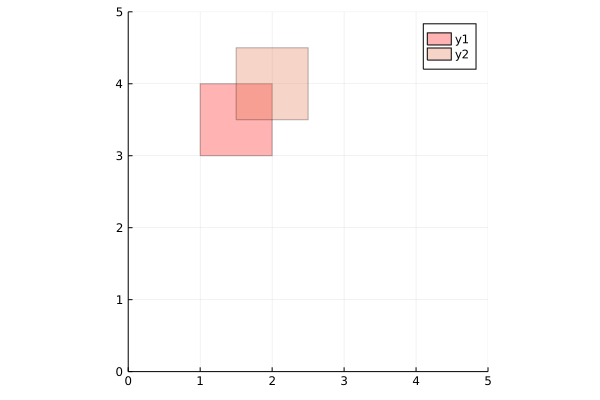

In [33]:
plot(X, alpha=0.3, c=:red, ratio=1, xlim=(0, 5), ylim=(0, 5))
plot!(IntervalBox(1.5..2.5, 3.5..4.5), alpha=0.3)

#### Exercise

1. Draw (an over-approximation of) the image of the unit square ($[0, 1] \times [0, 1]$) under the Hénon map:

    $$(x, y) \mapsto (1 - ax^2 + y, bx)$$

    for $a = 1.4$ and $b = 0.3$

    by using boxes.

In [46]:
x = 0..1
Xs = mince(x, 100)

a, b = 1.4, 0.3

henon(x, y) = SVector(1 - a*x^2 + y, b*x)

outputs = []

for x in Xs
    for y in Xs
        
        push!(outputs, IntervalBox(henon(x, y)))
        
    end
end

plot([x for x in outputs])




In [49]:
mince(X, 10)

100-element Array{IntervalBox{2,Float64},1}:
 [-5, -4] × [-5, -4]
 [-4, -3] × [-5, -4]
 [-3, -2] × [-5, -4]
 [-2, -1] × [-5, -4]
 [-1, 0] × [-5, -4]
 [0, 1] × [-5, -4]
 [1, 2] × [-5, -4]
 [2, 3] × [-5, -4]
 [3, 4] × [-5, -4]
 [4, 5] × [-5, -4]
 [-5, -4] × [-4, -3]
 [-4, -3] × [-4, -3]
 [-3, -2] × [-4, -3]
 ⋮
 [3, 4] × [3, 4]
 [4, 5] × [3, 4]
 [-5, -4] × [4, 5]
 [-4, -3] × [4, 5]
 [-3, -2] × [4, 5]
 [-2, -1] × [4, 5]
 [-1, 0] × [4, 5]
 [0, 1] × [4, 5]
 [1, 2] × [4, 5]
 [2, 3] × [4, 5]
 [3, 4] × [4, 5]
 [4, 5] × [4, 5]

In [34]:
henon(x, y) = x + y

henon (generic function with 1 method)

In [35]:
henon(1, 2)

3

In [37]:
henon( [1, 2] )

2-element SArray{Tuple{2},Float64,1,2} with indices SOneTo(2):
 1.6
 0.3

In [ ]:
henon(X...)

## Set inversion

By using enough boxes of a small enough size we can approximate any given (finite) set.

As an example, consider the problem of finding the set in the plane given by $S := \{(x, y) \in \mathbb{R}^2: 1 \le x^2 + y^2 \le 2 \}$.  This can be written as $f^{-1}([1, 2])$, with $f(x, y) := x^2 + y^2$, so corresponds to a **set inversion** problem.

Suppose we have an initial box

In [47]:
X = IntervalBox(-5..5, 2)

[-5, 5] × [-5, 5]

We would like to find the subset of $X$ that definitely lies *inside* $S$ and a subset that definitely lies *outside* $S$. We will do so by splitting up $X$ into pieces. The simplest way to try to do this is by mincing each direction of $X$ again. (Soon we will see a more sophisticated method.)

We will have to restrict ourselves to sets with a certain minimum size, so there will also be boxes that we cannot prove to be either inside or outside.

#### Exercise

1. Write a function to do carry out set inversion. 


2. Apply it to the above set-inversion problem and visualize the result.

In [80]:
function set_inversion(f, X, constraint, N)
    Xs = mince(X, N)
    
    inside = filter(x -> f(x) ⊆ constraint, Xs)  # \subseteq <TAB>
    outside = filter(x -> isempty(f(x) ∩ constraint), Xs)  # \subseteq <TAB>
    unknown = setdiff(Xs, vcat(inside, outside))
    
    return inside, outside, unknown
    # should do with if-else instead -- exercise
end

set_inversion (generic function with 1 method)

In [86]:
X = IntervalBox(-3..3, 2)

[-3, 3] × [-3, 3]

In [91]:
f( (x, y) ) = x^2 + y^2

inside, outside, unknown = set_inversion(f, X, 1..2, 100);

In [92]:
plot([x for x in inside], leg=false, ratio=1)
plot!([x for x in outside])
plot!([x for x in unknown])